### IMPORTING DATASET -KDDCUP99

In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

In [2]:
import pandas as pd
from tensorflow.keras.utils import get_file
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import Normalizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Lambda
from keras.layers import Embedding
from keras.layers import Convolution1D,MaxPooling1D, Flatten
from keras.datasets import imdb
from keras import backend as K
import pandas as pd
from keras.models import Sequential
from keras.layers import Convolution1D, Dense, Dropout, Flatten, MaxPooling1D
from keras.utils import np_utils
import numpy as np
import h5py
from keras import callbacks
from keras.layers import LSTM, GRU, SimpleRNN
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

Using TensorFlow backend.


In [3]:
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 5)

try:
    path = get_file('kdd-with-columns.csv', origin=\
    'https://github.com/jeffheaton/jheaton-ds2/raw/main/'\
    'kdd-with-columns.csv',archive_format=None)
except:
    print('Error downloading')
    raise
    
print(path) 

# Origional file: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
df = pd.read_csv(path)

print("Read {} rows.".format(len(df)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to 
# sample only 10% of the dataset
df.dropna(inplace=True,axis=1) 
# For now, just drop NA's (rows with missing values)


# display 5 rows
pd.set_option('display.max_columns', 5)
pd.set_option('display.max_rows', 5)
df

/home/rahul/.keras/datasets/kdd-with-columns.csv
Read 494021 rows.


,duration,protocol_type,...,dst_host_srv_rerror_rate,outcome
0,0,tcp,...,0.0,normal.
1,0,tcp,...,0.0,normal.
...,...,...,...,...,...
494019,0,tcp,...,0.0,normal.
494020,0,tcp,...,0.0,normal.


### ANALYSE DATASET

In [4]:
def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,\
                int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])
# Analyze KDD-99
analyze(df)


494021 rows
** duration:2495 (0%)
** protocol_type:[icmp:57.41%,tcp:38.47%,udp:4.12%]
** service:[ecr_i:56.96%,private:22.45%,http:13.01%,smtp:1.97%,other:1.46%,domain_u:1.19%,ftp_data:0.96%,eco_i:0.33%,ftp:0.16%,finger:0.14%,urp_i:0.11%,telnet:0.1%,ntp_u:0.08%,auth:0.07%,pop_3:0.04%,time:0.03%,csnet_ns:0.03%,remote_job:0.02%,imap4:0.02%,gopher:0.02%,domain:0.02%,discard:0.02%,systat:0.02%,iso_tsap:0.02%,shell:0.02%,echo:0.02%,rje:0.02%,sql_net:0.02%,whois:0.02%,printer:0.02%,nntp:0.02%,courier:0.02%,mtp:0.02%,netbios_ssn:0.02%,sunrpc:0.02%,vmnet:0.02%,bgp:0.02%,klogin:0.02%,uucp:0.02%,uucp_path:0.02%,nnsp:0.02%,ssh:0.02%,supdup:0.02%,login:0.02%,hostnames:0.02%,efs:0.02%,daytime:0.02%,link:0.02%,netbios_ns:0.02%,pop_2:0.02%,ldap:0.02%,http_443:0.02%,exec:0.02%,netbios_dgm:0.02%,kshell:0.02%,name:0.02%,ctf:0.02%,netstat:0.02%,Z39_50:0.02%,IRC:0.01%,urh_i:0.0%,X11:0.0%,tim_i:0.0%,tftp_u:0.0%,pm_dump:0.0%,red_i:0.0%]
** flag:[SF:76.6%,S0:17.61%,REJ:5.44%,RSTR:0.18%,RSTO:0.12%,SH:0.02%,S

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
duration                       494021 non-null int64
protocol_type                  494021 non-null object
service                        494021 non-null object
flag                           494021 non-null object
src_bytes                      494021 non-null int64
dst_bytes                      494021 non-null int64
land                           494021 non-null int64
wrong_fragment                 494021 non-null int64
urgent                         494021 non-null int64
hot                            494021 non-null int64
num_failed_logins              494021 non-null int64
logged_in                      494021 non-null int64
num_compromised                494021 non-null int64
root_shell                     494021 non-null int64
su_attempted                   494021 non-null int64
num_root                       494021 non-null int64
num_file_creations             494021 

## Log-scaled distribution of attacks


<Figure size 432x288 with 0 Axes>

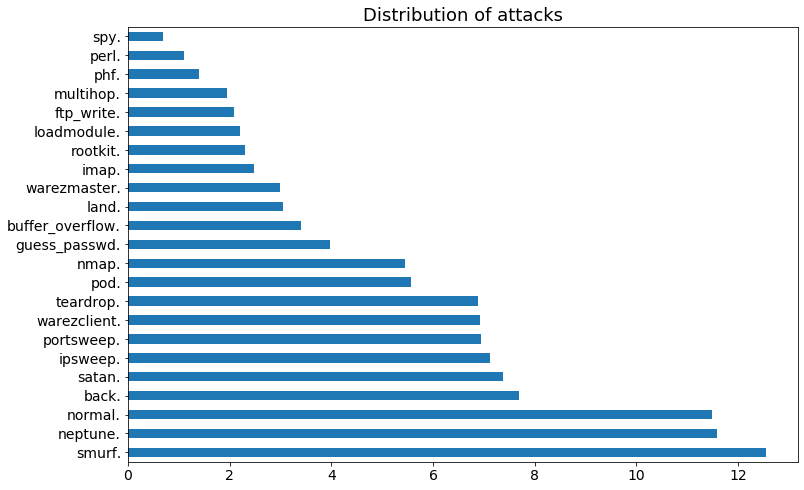

In [6]:
plt.clf()
plt.figure(figsize=(12,8))
params = {'axes.titlesize':'18',
          'xtick.labelsize':'14',
          'ytick.labelsize':'14'}
matplotlib.rcParams.update(params)
plt.title('Distribution of attacks')
#df.plot(kind='barh')
df['outcome'].value_counts().apply(np.log).plot(kind='barh')

plt.show()

## REMOVAL OF DUPLICATES











In [7]:
df.drop_duplicates(subset=None, keep='first', inplace=True)

### LABEL ENCODING

In [8]:
le=LabelEncoder()
df.service=le.fit_transform(df.service)
df['service']

0         22
1         22
          ..
494019    22
494020    22
Name: service, Length: 145586, dtype: int64

In [9]:
le=LabelEncoder()
df.protocol_type=le.fit_transform(df.protocol_type)
df

,duration,protocol_type,...,dst_host_srv_rerror_rate,outcome
0,0,1,...,0.0,normal.
1,0,1,...,0.0,normal.
...,...,...,...,...,...
494019,0,1,...,0.0,normal.
494020,0,1,...,0.0,normal.


In [10]:
le=LabelEncoder()
df.flag=le.fit_transform(df.flag)
df

,duration,protocol_type,...,dst_host_srv_rerror_rate,outcome
0,0,1,...,0.0,normal.
1,0,1,...,0.0,normal.
...,...,...,...,...,...
494019,0,1,...,0.0,normal.
494020,0,1,...,0.0,normal.


In [11]:
le=LabelEncoder()
df.outcome=le.fit_transform(df.outcome)
df

,duration,protocol_type,...,dst_host_srv_rerror_rate,outcome
0,0,1,...,0.0,11
1,0,1,...,0.0,11
...,...,...,...,...,...
494019,0,1,...,0.0,11
494020,0,1,...,0.0,11


### CREATING Y_TRAIN AND Y_TEST

In [12]:
y=df.iloc[:,-1]

In [13]:
y = np.array(y)
y


array([11, 11, 11, ..., 11, 11, 11])

In [14]:
y=to_categorical(y)

In [15]:
yt1 =y[:90000]
yt2=y[90000:]

### SPLIT DATASET TO TRAIN AND TEST

In [16]:
traindata= df.iloc[:90000,:]
testdata= df.iloc[90000:,:]

In [17]:
traindata.shape

(90000, 42)

In [18]:
testdata.shape

(55586, 42)

In [19]:
X = traindata.iloc[:,0:40]
T = testdata.iloc[:,0:40]


In [20]:

scaler = Normalizer().fit(X)
trainX = scaler.transform(X)

In [21]:
scaler = Normalizer().fit(T)
testT = scaler.transform(T)

In [22]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(trainX, (trainX.shape[0],trainX.shape[1],1))
X_test = np.reshape(testT, (testT.shape[0],testT.shape[1],1))

## MODELING

In [27]:
cnn = Sequential()
cnn.add(Convolution1D(64, 2, padding='same',activation="relu",input_shape=(120, 1)))
cnn.add(MaxPooling1D(pool_size=(2)))
cnn.add(Flatten())
cnn.add(Dense(128, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(23, activation="softmax"))

# cnn.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])
# checkpointer = callbacks.ModelCheckpoint(filepath="checkpoint/cnn/checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_accuracy',mode='max')
# csv_logger = CSVLogger('logs/cnnanalysis.csv',separator=',', append=False)
# cnn.fit(X_train, yt1, epochs=50,validation_data=(X_test, yt2),callbacks=[checkpointer,csv_logger],verbose=2)
# cnn.save("results/cnn/cnn_model.h5")")

# y_pred = cnn.predict_classes(X_test)



cnn.load_weights("../results/cnn/cnn_new_model.h5")
cnn.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
loss, accuracy = cnn.evaluate(X_test, yt1 )
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))

ValueError: Error when checking input: expected conv1d_3_input to have shape (120, 1) but got array with shape (40, 1)